# Predicting Member Renewals for a Cultural Institution (Classification Model)

### The Goal

The goal of this analysis to to see if we can effectively predict **both** whether a member is likely to renew and whether a member is likely not to renew.  And if we can, what are the main factors contributing to why a member might renew or not renew.

If we know someone is likely to renew, we can try scaling back our marketing efforts aimed at getting that person to renew. (ie spend less money on direct mail renewal notices)

If we know someone is likely to not renew, we can scale up our marketing efforts to get them to renew (ie send more direct mail renewal notices) OR, if appropriate, scale up our efforts to achieve something we know will increase the likelihood of renewal.  Ie if we know members are much more likely to renew their membership if they have visisted the institution at least 3 times during their membership period, we can run marketing campaigns aimed at getting people to visit more often.

In terms of how we fine-tune this model, we'll assume the following: It's more harmful to scale back renewal marketing efforts on a member and have them not renew (because we think they will renew) than it is to scale up renewal marketing efforts (because we think they won't renew).  So we want to be more cautious about taking people out of marketing efforts than adding people to marketing efforts.

In other words, we want a high Precision score when it comes to identifying people who will renew. And we want a high Recall score when it comes to identifying people who will NOT renew.



### The Data

<br>

The  data for this analysis was scattered over 12 tables. Below is a simplified view of the key tables that were used.  I'm not including all of the tables because some where used to fill in gaps in the data, not for creating new features.

Because of gaps in the data, I'm limited to looking at a five month period of initial membership purchases, plus 12 months of activity following that initial membership purchase (ie admission ticket purchases while you're a member).  Ideally this analysis would span several years.

Columns in **bold** were used to create columns in the final table.

Also, FYI: There are three types of transactions a person can have with the institute: 1) Admission ticket purchase to enter the building, 2) an annual Membership (there are many levels of membership), and 3) a donation.

<br>

**Table 1: Transactions**<br>
> **cons_id** - Constituent ID<br>
> **order_id** - Transaction ID<br>
> **transaction_date** - Transaction date<br>
> **channel** - Channel the transaction was made (e.g. website, in-person, kiosk)<br>
> **ticket_amt** - If admission tickets were purchased, the total amount of that purchase<br>
> **member_amt** - If a membership was purchased, the total amount of that purchase <br>
> **donation_amt** - If a donation was made, this is the donation amount (it's possible to add a donation when purchasing a ticket or membership)<br>
> **total_amt** - Total amount of the transaction (tickets + membership + donation)

I used the Member amount data to identify member purchases during the five-month period for analysis.  With the membership purchase date, I'm able to calculate the membership expiration date.

I used the ticket and donation amount data to count how many times tickets and donations were made during a membership (between initial purchase date and membership expiration date), with the theory being that more tickets or donations may mean a higher probability of renewing.

Because general admission tickets are free to members, sometimes ticket amounts are zero but still represent a ticket transaction.  Those were identified by flagging transactions where ticket amount, member amount, and donation amount were all zero. This was summarized in the final table by the columns by denoted "free" and "paid" ticket columns.  




**Tables 2, 3, 4: Ticket Transactions, Membership Transactions, Donation Transactions**<br>
> re_id - Constituent ID from Raiser's Edge (different from cons_id)<br>
> cons_id - Constituent ID<br>
> re_gift_id - Raiser's Edge transaction ID<br>
> re_gift_date - Transaction date<br>
> campaign_split_amount - Purchase amount<br>
> campaign - Marketing campaign<br>
> channel - Channel the transaction was made (e.g. website, in-person, kiosk)<br>
> fiscal_year - fiscal year<br>
> appeal_category - Marketing appeal category<br>
> appeal_name - Marketing appeal<br>
> appeal_id - Marketing appeal id<br>
> **first_gift_date** - Date of first transaction with institute<br>
> **first_gift_amt** - Amount transacted in first transaction with institute<br>

I used the last three columns to add a new feature that counted how long it has been since a person first transacted with the institute.  Ideally I would have access to all prior engagement data, not just the first transaction.


**Table 5: Membership Transactions (different data from Tables 2-4)**<br>
> re_gift_id - Raiser's Edge transaction ID<br>
> fund_description - Accounting info<br>
> amount - Transaction amount<br>
> transaction_date - Transaction date<br>
> payment_type - Payment type<br>
> campaign_id - Marketing campaign id<br>
> ***membership_type*** - Indicates whether the membership purchase was Joined, Renewed, or Upgraded<br>
> gift_type - junk data<br>
> gift_channel - Channel the transaction was made (e.g. website, in-person, kiosk)<br>

I used the membership_type to indicate if the initial membership purchase during the five-month period was someone buying their first membership, someone renewing an existing membership, someone upgrading an existing membership, or someone downgrading an existing membership.


**Table 6: Member Info**<br>
> re_id<br>
> First_Name<br>
> Last_Name<br>
> cons_id<br>
> ***Address1***<br>
> ***Address2***<br>
> ***City***<br>
> ***State***<br>
> ***ZIP***<br>
> Email<br>

We already know from working with the institute that proximity to the institute is a factor in visitation.  I used member addresses to calculate lat/long points so that I could quantify how far each member lives from the institute (see next table).

**Table 7: Member Lat Long** - Using addresses from Table 6, I converted found the latitude and longitude for each member.  Since this was only for ~13K records, I used a Google Sheets script I already had to geocode the addresses.  
> cons_id
> **latititude** 
> **longitude** <br>

With the lat/long, I ran a mysql query to find the distance in miles from each member's home to the institute: 
round(ST_Distance_Sphere(point(member_location_long, member_location_lat), point(institute_long, institute_lat)) * .000621371192,0)

This distance calculation is imperfect because it does not reflect actual travel time by car or public transit. Ie one member could be two miles away and get to the institute in 15 minutes by bus. Another member could also be two miles away - but on the other side of a river - and have to drive 45 minutes to get to the institute. Ideally I would be able to leverage somethine like Google Maps API to calculate the fastest travel time instead.


**Table 8: Member Demographic Data** - I added this in but I could only match about 10% of the members I'm focusing on I ended up stipping this out of the final table.
> cons_id<br>
> age_range <br>
> gender<br>
> marital_status<br>
> children_in_household<br>
> education<br>
> household_income<br>
> net_worth<br>
> estimated_home_value<br>
> predicted_discretionary_spending<br>
> giving_affinity<br>





### Import libraries

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

from utils import extract_dates, get_val_scores
from category_encoders import TargetEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from pdpbox import pdp, get_dataset, info_plots

### Import Data

In [3]:
dtypes = {
    'zip': 'object'
}

df = pd.read_csv('/Users/cameronlefevre/Data Science/coding/GA-DS-Class/Homework/Unit4/data/members.csv', dtype=dtypes, parse_dates=['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date'])

df.head()

,mem_purchase_date,mem_purchase_amt,mem_purchase_channel,mem_purchase_type,mem_expiration_date,donation_transaction_count,donation_total_amount,donation_addon_transaction_count,donation_addon_total_amt,ticket_transaction_count,...,demo_children_in_household,demo_education,demo_household_income,demo_net_worth,demo_estimated_home_value,demo_predicted_discretionary_spending,demo_giving_affinity,zip,miles_to_museum,renewed
0,2016-01-01,140.0,POS,Renewal,2017-01-31,0,NaN,0,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11731,NaN,No
1,2016-01-01,95.0,Mobile Web,Joined,2017-01-31,0,NaN,0,NaN,2,...,No,Graduate Degree,$200K - $250K,$500K - $1MM,$500K - $1MM,$25K - $50K,Arts and Culture: Low Dollar,10128,NaN,No
2,2016-01-01,105.0,Web,Joined,2017-01-31,0,NaN,0,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10025,NaN,No
3,2016-01-01,140.0,POS,Joined,2017-01-31,0,NaN,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11050,14.0,No
4,2016-01-01,250.0,Web,Renewal,2017-01-31,0,NaN,0,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13525 entries, 0 to 13524
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   mem_purchase_date                      13525 non-null  datetime64[ns]
 1   mem_purchase_amt                       13525 non-null  float64       
 2   mem_purchase_channel                   13525 non-null  object        
 3   mem_purchase_type                      11290 non-null  object        
 4   mem_expiration_date                    13525 non-null  datetime64[ns]
 5   donation_transaction_count             13525 non-null  int64         
 6   donation_total_amount                  28 non-null     float64       
 7   donation_addon_transaction_count       13525 non-null  int64         
 8   donation_addon_total_amt               10 non-null     float64       
 9   ticket_transaction_count               13525 non-null  int64 

Of the membership purchases we're working with, how many went on to renew their membership?  

In [5]:
df['renewed'].value_counts()

No     11323
Yes     2202
Name: renewed, dtype: int64

### Initial model to see where we're starting from

In [6]:
mod1 = xgb.XGBClassifier()
pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)

X = df.drop(['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date', 'renewed'], axis=1)
y = np.where(df['renewed'] == 'Yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)
val_scores = cross_val_score(pipe, X=X_train, y=y_train, cv=5)

val_scores.mean(), val_scores

(0.828003696857671,
 array([0.82624769, 0.82763401, 0.82208872, 0.8271719 , 0.83687616]))

In [7]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8199630314232902

In [8]:
y_true = y_test
y_pred = pipe.predict(X_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      2265
           1       0.41      0.25      0.31       440

    accuracy                           0.82      2705
   macro avg       0.64      0.59      0.60      2705
weighted avg       0.79      0.82      0.80      2705



We have a good Recall score for identifying people who won't renew and we have a low Precision score for identifying people who will renew.

Let's see if things are any better if we use ordinal encoding for some of the fields.  We'll do this manually to ensure the values are ranked appropriately.

In [9]:
age_categories = pd.Categorical(df['demo_age_range'], categories=['Age: 0-20', 'Age: 21-33', 'Age: 34-43', 'Age: 44-53', 'Age: 54-63', 'Age: 64+'], ordered=True)
labels, unique = pd.factorize(age_categories, sort=True)
df['demo_age_range'] = labels

edu_categories = pd.Categorical(df['demo_education'], categories=['Less than HS Diploma', 'High School Diploma', 'Some College', 'Bachelors Degree', 'Graduate Degree'], ordered=True)
labels, unique = pd.factorize(edu_categories, sort=True)
df['demo_education'] = labels

income_categories = pd.Categorical(df['demo_household_income'], categories=['$1K - $50K', '$50K - $75K', '$75K - $100K', '$100K - $125K', '$125K - $150K', '$150K - $175K', '$175K - $200K', '$200K - $250K', '$250K+'], ordered=True)
labels, unique = pd.factorize(income_categories, sort=True)
df['demo_household_income'] = labels

worth_categories = pd.Categorical(df['demo_net_worth'], categories=['$0 - $100K', '$100K - $250K', '$250K - $500K', '$500K - $1MM', '$1MM - $10MM', '$10MM - $25MM'], ordered=True)
labels, unique = pd.factorize(worth_categories, sort=True)
df['demo_net_worth'] = labels

hv_categories = pd.Categorical(df['demo_estimated_home_value'], categories=['$0 - $100K', '$100K - $250K', '$250K - $500K', '$500K - $1MM', '$1MM - $10MM'], ordered=True)
labels, unique = pd.factorize(hv_categories, sort=True)
df['demo_estimated_home_value'] = labels

spending_categories = pd.Categorical(df['demo_predicted_discretionary_spending'], categories=['$0 - $10K', '$10K - $25K', '$25K - $50K', '$50K - $100K', '$100K - $250K'], ordered=True)
labels, unique = pd.factorize(spending_categories, sort=True)
df['demo_predicted_discretionary_spending'] = labels


In [10]:
mod1 = xgb.XGBClassifier()
pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)

X = df.drop(['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date', 'renewed'], axis=1)
y = np.where(df['renewed'] == 'Yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

val_scores = cross_val_score(pipe, X=X_train, y=y_train, cv=5)

val_scores.mean(), val_scores

(0.8256007393715341,
 array([0.82255083, 0.82578558, 0.82578558, 0.82486137, 0.82902033]))

In [11]:
pipe.fit(X_train, y_train)

y_true = y_test
y_pred = pipe.predict(X_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2265
           1       0.42      0.26      0.32       440

    accuracy                           0.82      2705
   macro avg       0.65      0.59      0.61      2705
weighted avg       0.79      0.82      0.80      2705



Scores are slightly better so we'll keep the new columns.

Since the classes are not balanced, let's try finding a better weight to use.  We'll focus on increasing the precision score since that is so low.

In [12]:
weight_values = [1, 5, 6, 7, 10, 15, 20]

scores_weights_df = pd.DataFrame(columns=['precision score', 'f1 score','average kfold score','weight', 'kfold_scores'])

mod1 = xgb.XGBClassifier()
pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)

for weight in weight_values:

    pipe.steps[2][1].set_params(scale_pos_weight=weight)
    scores = cross_val_score(pipe, X=X_train, y=y_train, cv=5)

    pipe.fit(X_train, y_train)

    y_true = y_test
    y_pred = pipe.predict(X_test)

    precisionscore = precision_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    
    new_row = {'precision score': precisionscore, 'f1 score':f1score, 'average kfold score':scores.mean(), 'weight':weight, 'kfold_scores':scores}
    scores_weights_df = scores_weights_df.append(new_row, ignore_index=True)

                
scores_weights_df.sort_values(by=['precision score'], ascending=False, inplace=True)

scores_weights_df

,precision score,f1 score,average kfold score,weight,kfold_scores
0,0.424812,0.320113,0.825601,1,"[0.822550831792976, 0.8257855822550831, 0.8257..."
1,0.361345,0.447140,0.766081,5,"[0.7624768946395564, 0.7527726432532348, 0.761..."
2,0.346354,0.440397,0.757209,6,"[0.7523105360443623, 0.7546210720887245, 0.745..."
3,0.340881,0.438866,0.747043,7,"[0.7375231053604436, 0.7352125693160814, 0.739..."
4,0.326840,0.442815,0.727079,10,"[0.7144177449168208, 0.7245841035120147, 0.721..."
5,0.306022,0.426703,0.701386,15,"[0.6922365988909427, 0.7084103512014788, 0.707..."
6,0.282074,0.406844,0.683087,20,"[0.6682070240295749, 0.6959334565619224, 0.680..."


Looks like weight=1 is the best option (makes sense since we're focusing on Precision). We could increase the weight to get a better F1 score, but that would decrease our precision.  I would rather be more confident in identifying people who are going to renew than be better at capturing more people who might renew.

### Feature Engineering

Most of the feature engineering was done already in mysql.  But let's try to do a little bit more.

First, let's add some easy column related to the dates.

In [13]:
df['days_since_first_transaction'] = (df['mem_purchase_date'] - df['very_first_transaction_date']).dt.days

df = extract_dates(df, cols=['mem_purchase_date'], drop_cols=False, date_parts=['dayofyear', 'day', 'month'])

Although we don't have demographic data for most members, we do have zip code for most.  Let's use zip to get a couple median wealth-related values as a rough proxy for an individual's wealth. For this, we'll use uszipcode to pull in a couple of data points from the Census.  

In [14]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True, db_file_dir="/Users/cameronlefevre/Data Science")

median_home_values = []
median_household_income = []

for i, row in df.iterrows():
    
    if isinstance(row['zip'], float):
        median_home_values.append(np.nan)
        median_household_income.append(np.nan)
    else:
        zip_info = search.by_zipcode(int(row['zip']))

        if zip_info.values()[0] == "":
            median_home_values.append(np.nan)
            median_household_income.append(np.nan)
        else:
            median_home_values.append(zip_info.to_dict()['median_home_value'])
            median_household_income.append(zip_info.to_dict()['median_household_income'])
            
df['median_home_values'] = median_home_values
df['median_household_income'] = median_household_income

Let's see what these new features do to the model

In [15]:
mod1 = xgb.XGBClassifier()
pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)

X = df.drop(['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date', 'renewed'], axis=1)
y = np.where(df['renewed'] == 'Yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)
val_scores = cross_val_score(pipe, X=X_train, y=y_train, cv=5)

val_scores.mean(), val_scores

(0.827634011090573,
 array([0.82347505, 0.82578558, 0.82578558, 0.82994455, 0.8331793 ]))

In [16]:
pipe.fit(X_train, y_train)

y_true = y_test
y_pred = pipe.predict(X_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2265
           1       0.48      0.28      0.36       440

    accuracy                           0.83      2705
   macro avg       0.68      0.61      0.63      2705
weighted avg       0.81      0.83      0.82      2705



A bit more improvement.

In [17]:
feats = pd.DataFrame({ 'Importance': pipe.steps[2][1].feature_importances_, 'Column': pipe.steps[2][1].get_booster().feature_names})
feats.sort_values(by='Importance', ascending=False, inplace=True)

pd.set_option('display.max_rows', 100)

feats

,Importance,Column
9,0.133355,mem_purchase_type_Renewal
7,0.125083,mem_purchase_type_Joined
41,0.068319,zip
1,0.047299,mem_purchase_channel_POS
2,0.042143,mem_purchase_channel_Kiosk
4,0.038722,mem_purchase_channel_Web
16,0.032809,ticket_transaction_count
8,0.022812,mem_purchase_type_nan
21,0.019067,demo_age_range
38,0.018262,demo_giving_affinity_Super Donors


In [18]:
feats['Importance'].cumsum()

9     0.133355
7     0.258438
41    0.326757
1     0.374056
2     0.416198
4     0.454920
16    0.487729
8     0.510541
21    0.529608
38    0.547870
30    0.565988
17    0.582303
25    0.598594
32    0.614711
43    0.630739
40    0.646678
31    0.662394
44    0.677851
26    0.693076
0     0.707953
23    0.722825
49    0.737534
20    0.752035
34    0.766500
11    0.780819
24    0.795093
19    0.809047
48    0.822997
3     0.836927
39    0.850504
33    0.863910
29    0.877265
42    0.890553
45    0.903489
27    0.914942
35    0.926010
5     0.936741
37    0.947334
36    0.957548
13    0.967415
18    0.977211
12    0.986061
28    0.994906
22    1.000000
10    1.000000
6     1.000000
14    1.000000
15    1.000000
46    1.000000
47    1.000000
Name: Importance, dtype: float32

Let's try dropping the least impactful original fields.

In [19]:
df.drop(['donation_total_amount',
         'ticket_transaction_count_paid', 
         'donation_transaction_count', 
         'donation_addon_transaction_count',
         'donation_addon_total_amt',
         'mem_purchase_date_month',
         'mem_purchase_date_history_days'], axis=1, inplace=True)

In [20]:
mod1 = xgb.XGBClassifier()
pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)

X = df.drop(['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date', 'renewed'], axis=1)
y = np.where(df['renewed'] == 'Yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)
val_scores = cross_val_score(pipe, X=X_train, y=y_train, cv=5)

val_scores.mean(), val_scores

(0.8284658040665434,
 array([0.82255083, 0.8267098 , 0.82994455, 0.8267098 , 0.83641405]))

In [21]:
pipe.fit(X_train, y_train)

y_true = y_test
y_pred = pipe.predict(X_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2265
           1       0.49      0.29      0.36       440

    accuracy                           0.83      2705
   macro avg       0.68      0.61      0.63      2705
weighted avg       0.81      0.83      0.82      2705



Tiny improvement.

### Model Tuning

We'll try moving on to model tuning.

In [22]:
X = df.drop(['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date', 'renewed'], axis=1)
y = np.where(df['renewed'] == 'Yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

n_estimators  = [100, 250, 500]
learning_rate = [.05, 0.1, 0.2]
max_depth     = [3, 4, 5]

scores_df = pd.DataFrame(columns=['precision score', 'f1 score','average kfold score','n_estimators','learning_rate','max_depth','kfold_scores'])

# cycle through our model parameters
for estimators in n_estimators:
    for rate in learning_rate:
        for depth in max_depth: 
            mod1 = xgb.XGBClassifier(n_estimators=estimators, learning_rate=rate, max_depth=depth)
            pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)
            scores = cross_val_score(pipe, X=X_train, y=y_train, cv=5)

            pipe.fit(X_train, y_train)

            y_true = y_test
            y_pred = pipe.predict(X_test)

            precisionscore = precision_score(y_true, y_pred)
            f1score = f1_score(y_true, y_pred)

            new_row = {'precision score':precisionscore, 'f1 score':f1score, 'average kfold score':scores.mean(), 'n_estimators':estimators, 'learning_rate':rate, 'max_depth':depth, 'kfold_scores':scores}
            scores_df = scores_df.append(new_row, ignore_index=True)

                
scores_df.sort_values(by=['precision score'], ascending=False, inplace=True)

In [23]:
scores_df

,precision score,f1 score,average kfold score,n_estimators,learning_rate,max_depth,kfold_scores
10,0.543478,0.320513,0.836784,250,0.05,4,"[0.8368761552680222, 0.8359519408502772, 0.834..."
0,0.535433,0.239859,0.836322,100,0.05,3,"[0.838724584103512, 0.838724584103512, 0.83595..."
1,0.526316,0.244328,0.836599,100,0.05,4,"[0.8368761552680222, 0.8391866913123844, 0.835..."
7,0.520548,0.345979,0.835305,100,0.20,4,"[0.8299445471349353, 0.8341035120147874, 0.836..."
4,0.518717,0.309410,0.837893,100,0.10,4,"[0.838724584103512, 0.838724584103512, 0.83780..."
8,0.517857,0.349398,0.832440,100,0.20,5,"[0.8350277264325323, 0.8341035120147874, 0.829..."
9,0.517045,0.295455,0.837153,250,0.05,3,"[0.8359519408502772, 0.8419593345656192, 0.834..."
15,0.510638,0.355556,0.835952,250,0.20,3,"[0.8341035120147874, 0.8345656192236599, 0.841..."
2,0.509202,0.275290,0.835028,100,0.05,5,"[0.8354898336414048, 0.8405730129390019, 0.827..."
18,0.507937,0.305246,0.836322,500,0.05,3,"[0.833641404805915, 0.8424214417744916, 0.8378..."


### Another attempt at addressing our unbalanced class

Since our class is a unbalanced and scale_pos_weight didn't help, we'll try a combination of over- and undersampling.  We'll oversample a bit of our minority class and then undersample our majority class.

With more time, I would test a variety of arrangements here... ie just using oversampling, just using undersampling, etc.


In [26]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [27]:
X1 = df.drop(['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date', 'renewed'], axis=1)
y1 = np.where(df['renewed'] == 'Yes', 1, 0)

In [28]:
print(Counter(y1))

Counter({0: 11323, 1: 2202})


In [30]:
over = RandomOverSampler(sampling_strategy=0.5)
X1, y1 = over.fit_resample(X1, y1)
print(Counter(y1))

Counter({0: 11323, 1: 5661})


In [31]:
under = RandomUnderSampler(sampling_strategy=1)
X1, y1 = under.fit_resample(X1, y1)
print(Counter(y1))

Counter({0: 5661, 1: 5661})


In [34]:
mod1 = xgb.XGBClassifier(n_estimators=250, learning_rate=0.05, max_depth=4)
pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42, shuffle=True)

val_scores = cross_val_score(pipe, X=X_train, y=y_train, cv=5)

val_scores.mean(), val_scores

(0.7777419814891336,
 array([0.77041943, 0.77593819, 0.78575373, 0.78796245, 0.76863611]))

In [35]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7849889624724061

In [36]:
y_true = y_test
y_pred = pipe.predict(X_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.78      1133
           1       0.76      0.83      0.79      1132

    accuracy                           0.78      2265
   macro avg       0.79      0.79      0.78      2265
weighted avg       0.79      0.78      0.78      2265



Our Precision improved quite a bit, though as expected it came at the expense of the Recall score.  I'm ok with this!

### Post Morten Analysis

#### How purchase type (e.g. Joined, Renewed) impacts likelihood to renew

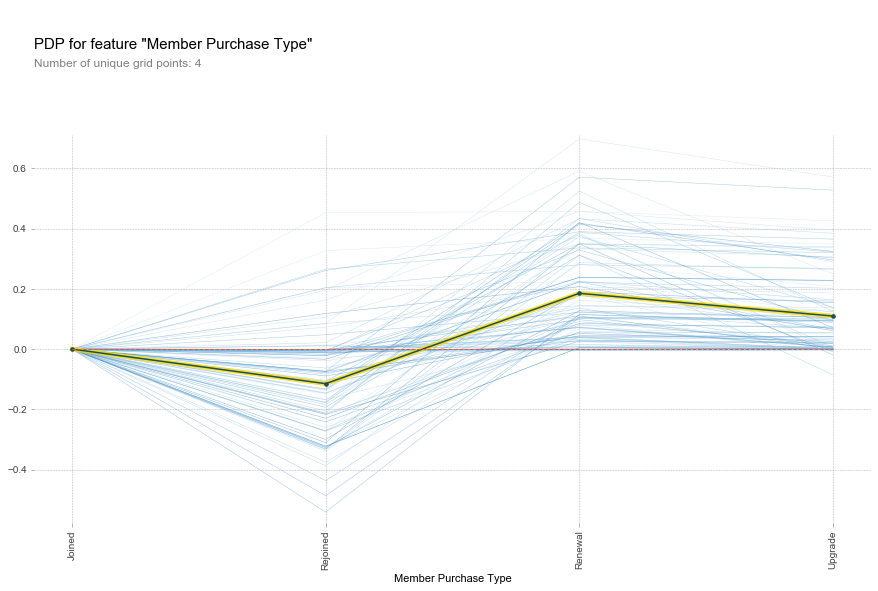

In [48]:
mem_purchase_type_cols = ['mem_purchase_type_Joined', 'mem_purchase_type_Rejoined', 'mem_purchase_type_Renewal', 'mem_purchase_type_Upgrade']

pdp_mem_purchase_type = pdp.pdp_isolate(
    model = pipe[2], 
    dataset = pipe[1].transform(pipe[0].transform(X_train)), 
    model_features = pipe[1].get_feature_names(), 

    feature = mem_purchase_type_cols
)

fig, axes = pdp.pdp_plot(pdp_mem_purchase_type, 'Member Purchase Type', plot_lines=True, frac_to_plot=100)

xtick_labels = [purchase_type.split('mem_purchase_type_')[1] for purchase_type in mem_purchase_type_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

This makes sense, intuitively.  The chart shows that someone who joined (became a member) or rejoined (has been several years since that person was previously a member) is less likely to renew compared to someone who renewed or upgraded (someone who currently has an active membership).  (We already know this from a simple retention rate analysis of first-year members vs multi-year members.)

What's most interesting is that existing members who Upgraded seem slightly less likely to renew in the future than members who renewed without upgrading.  That's worth exploring further.

It's also noteworthy that people who rejoined are less likely to renew than people who joined.  That's another area worth exploring further.

### How purchase channel impacts likelihood to renew

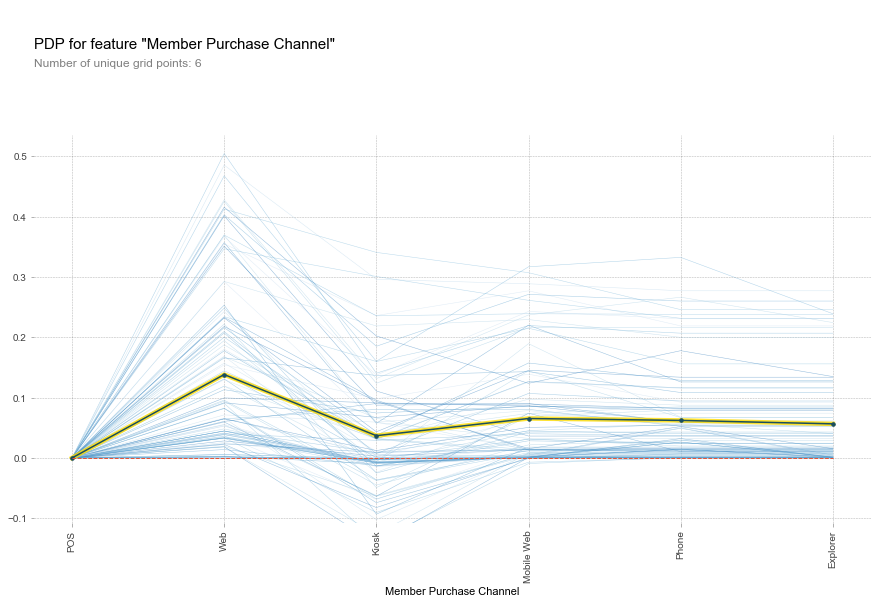

In [38]:
mem_purchase_channel_cols = [col for col in pipe[1].get_feature_names() if 'mem_purchase_channel' in col]

pdp_mem_purchase_channel = pdp.pdp_isolate(
    model = pipe[2], 
    dataset = pipe[1].transform(pipe[0].transform(X_train)), 
    model_features = pipe[1].get_feature_names(), 

    feature = mem_purchase_channel_cols
)

fig, axes = pdp.pdp_plot(pdp_mem_purchase_channel, 'Member Purchase Channel', plot_lines=True, frac_to_plot=100)

xtick_labels = [purchase_channel.split('mem_purchase_channel_')[1] for purchase_channel in mem_purchase_channel_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

### How does children-in-household impact renewal?

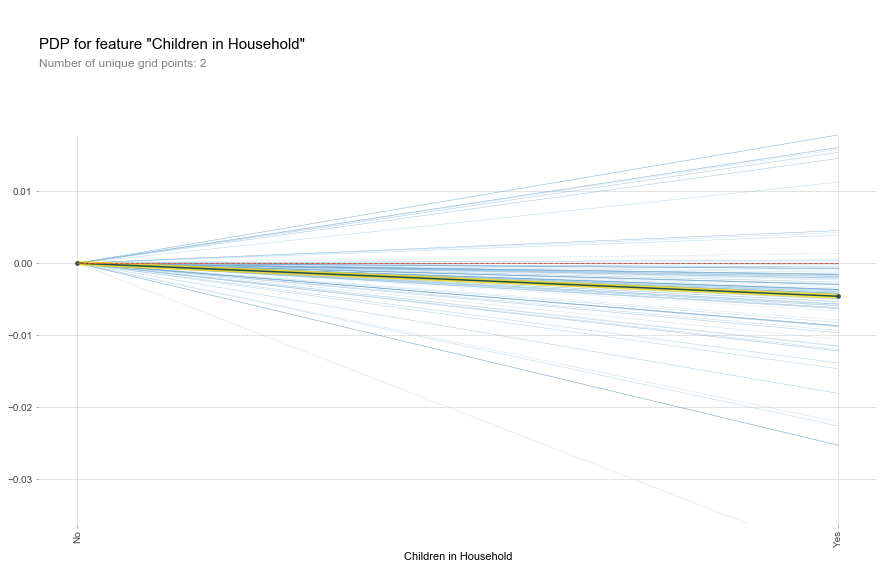

In [41]:
demo_children_in_household_cols = ['demo_children_in_household_No', 'demo_children_in_household_Yes']

pdp_demo_children_in_household = pdp.pdp_isolate(
    model = pipe[2], 
    dataset = pipe[1].transform(pipe[0].transform(X_train)), 
    model_features = pipe[1].get_feature_names(), 

    feature = demo_children_in_household_cols
)

fig, axes = pdp.pdp_plot(pdp_demo_children_in_household, 'Children in Household', plot_lines=True, frac_to_plot=100)

xtick_labels = [children.split('demo_children_in_household_')[1] for children in demo_children_in_household_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

### How does household income impact renewal?

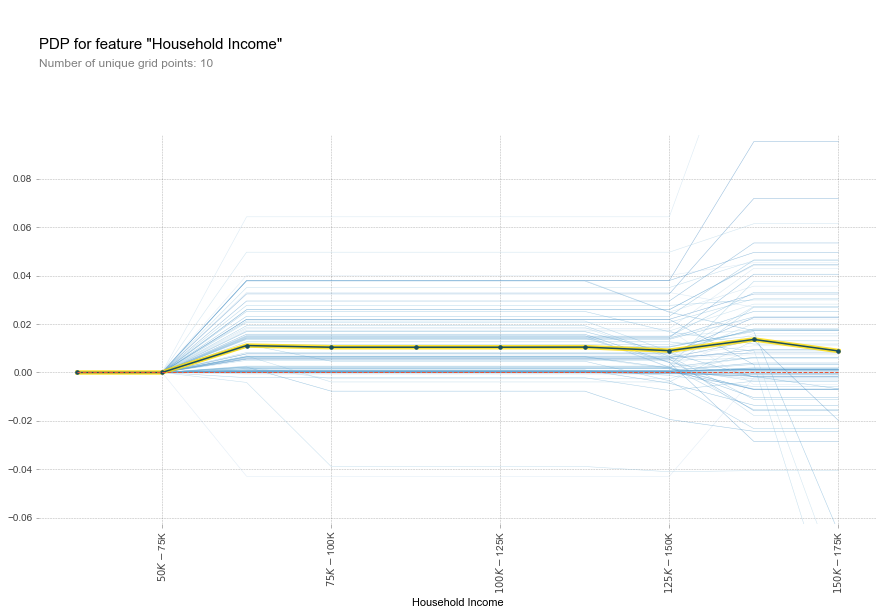

In [42]:
pdp_income = pdp.pdp_isolate(
    model = pipe[2],
    dataset = pipe[1].transform(pipe[0].transform(X_train)), 
    model_features = pipe[1].get_feature_names(), 
    feature='demo_household_income', 
    cust_grid_points = pipe[0].transform(X_train)['demo_household_income'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_income, 'Household Income', plot_lines=True, frac_to_plot=100)

xtick_labels = ['$1K - $50K', '$50K - $75K', '$75K - $100K', '$100K - $125K', '$125K - $150K', '$150K - $175K', '$175K - $200K', '$200K - $250K', '$250K+']
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

### How does the number of ticket orders by the member impact renewal?

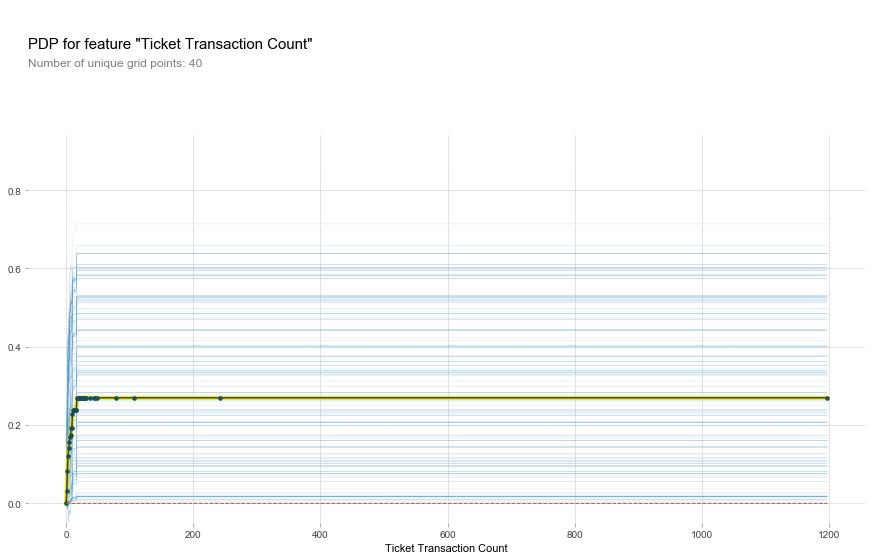

In [43]:
pdp_ticket_transaction_count = pdp.pdp_isolate(
    model=pipe[2],
    dataset = pipe[1].transform(pipe[0].transform(X_train)), 
    model_features=pipe[1].get_feature_names(), 
    feature='ticket_transaction_count', 
    cust_grid_points = pipe[0].transform(X_train)['ticket_transaction_count'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_ticket_transaction_count, 'Ticket Transaction Count', plot_lines=True, frac_to_plot=100)

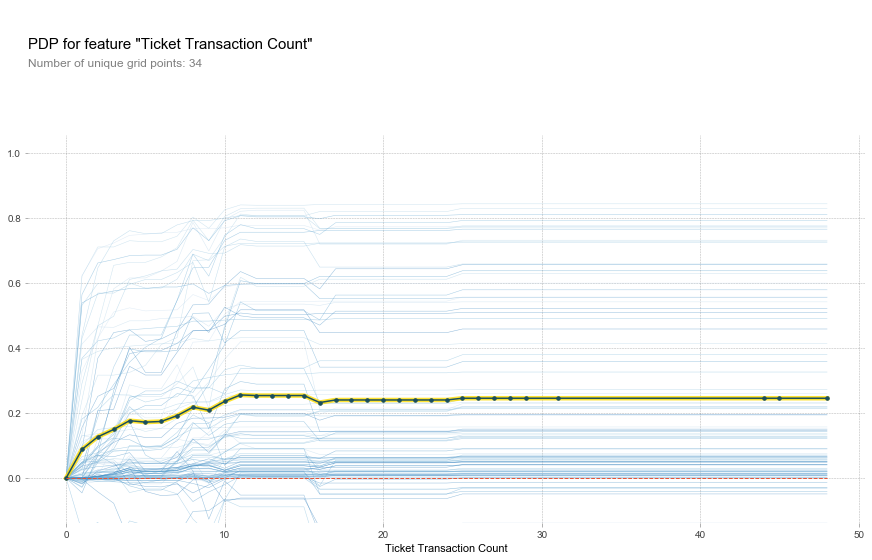

In [44]:
# There are five records that are skewing the visualization of the Ticket Transaction Count table, 
# so let's remove those and try it again

df_2 = df[df['ticket_transaction_count'] < 50].copy()

X2 = df_2.drop(['mem_purchase_date', 'mem_expiration_date', 'very_first_transaction_date', 'renewed'], axis=1)
y2 = np.where(df_2['renewed'] == 'Yes', 1, 0)

over = RandomOverSampler(sampling_strategy=0.5)
X2, y2 = over.fit_resample(X2, y2)

under = RandomUnderSampler(sampling_strategy=1)
X2, y2 = under.fit_resample(X2, y2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42, shuffle=True)

mod1 = xgb.XGBClassifier(n_estimators=250, learning_rate=0.1, max_depth=5)
pipe = make_pipeline(TargetEncoder(cols=['zip']), OneHotEncoder(use_cat_names=True), mod1)
pipe.steps[2][1].set_params(scale_pos_weight=5)

pipe.fit(X_train2, y_train2);

pdp_ticket_transaction_count = pdp.pdp_isolate(
    model=pipe[2],
    dataset = pipe[1].transform(pipe[0].transform(X_train2)), 
    model_features=pipe[1].get_feature_names(), 
    feature='ticket_transaction_count', 
    cust_grid_points = pipe[0].transform(X_train2)['ticket_transaction_count'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_ticket_transaction_count, 'Ticket Transaction Count', plot_lines=True, frac_to_plot=100)

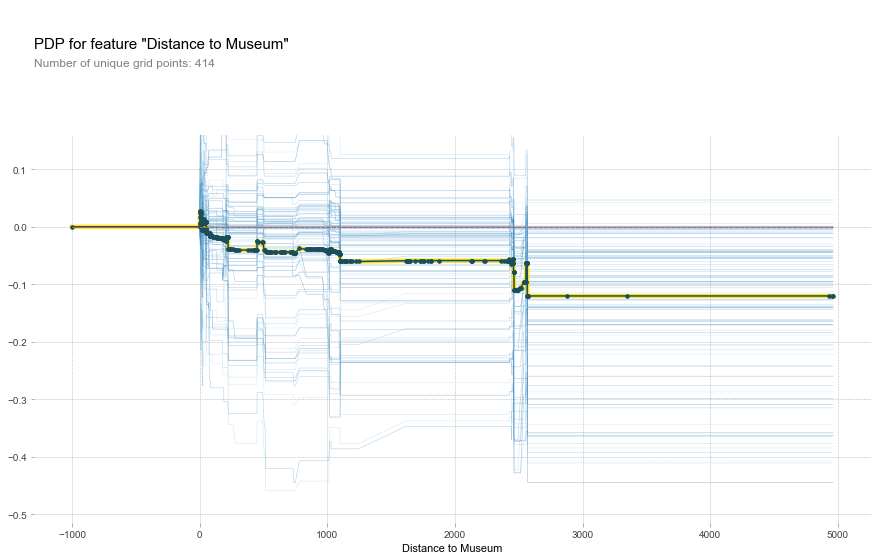

In [45]:
# Replace the null distances with -1000
X_train_2 = X_train.copy()
X_train_2['miles_to_museum'].fillna(-1000, inplace = True)

pdp_miles_to_museum = pdp.pdp_isolate(
    model=pipe[2],
    dataset = pipe[1].transform(pipe[0].transform(X_train_2)), 
    model_features=pipe[1].get_feature_names(), 
    feature='miles_to_museum', 
    cust_grid_points = pipe[0].transform(X_train_2)['miles_to_museum'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_miles_to_museum, 'Distance to Museum', plot_lines=True, frac_to_plot=100)

### Conclusions

My main takeaway is that we just need more data for this model.  Five months of membership purchases and subsequent renewals/lapses is a fraction of the data the institution actually has.  Additionally, it may be worth paying to try to further flesh out demographic data.  With that additional data, I would want to explore layering in clustering to see if that helps improve the model.

My secondary take is that the model supports some of my initial assumptions - that more ticket purchases and closer proximity to the institution are linked to higher renewal rates.